In [44]:
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostRanker,Pool


In [ ]:
train=pd.read_parquet('../Data/small_train_engineered.parquet',engine='pyarrow')
val=pd.read_parquet('../Data/small_val_engineered.parquet',engine='pyarrow')

In [46]:
train

,id2,id3,id4,id5,y,f1,f2,f5,f6,f7,...,f349_sin,f349_cos,time_since_last,session_event_count,offer_category,num_offer_categories,sub_category,num_sub_categories,previous_offer_category,previous_suboffer_category
0,1000624,5243695,2023-11-01 03:31:21.598,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,-0.433884,-0.900969,NaN,1,Shopping,1,Other,1,missing,missing
1,1000624,97646,2023-11-01 03:31:21.618,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,-0.433884,-0.900969,0.020,2,Shopping,1,Apparel,1,Shopping,Other
2,1000639,81010,2023-11-01 13:00:17.848,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,NaN,1,Shopping,1,Other,1,missing,missing
3,1000639,830157,2023-11-01 13:00:20.013,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,2.165,2,Shopping,1,Gifts,1,Shopping,Other
4,1000639,24840,2023-11-01 13:00:22.564,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,2.551,3,Shopping,1,Clothing_Gifts_Jewelry,3,Shopping,Gifts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124373,1910541,80107221,2023-11-01 05:46:56.017,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,1.993,3,Shopping,1,Other,1,Services,None
124374,1910541,224505,2023-11-01 07:43:02.618,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,6966.601,4,Shopping,1,Other,1,Shopping,Other
124375,1910541,5420674,2023-11-01 07:43:31.173,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,28.555,5,Shopping,1,Other,1,Shopping,Other
124376,1910541,82192,2023-11-01 07:43:31.452,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,0.279,6,Shopping,1,Clothing,1,Shopping,Other


In [47]:
# --- YOUR HACKATHON METRIC FUNCTION ---
def map_at_k_hackathon(y_true, y_pred_scores, group_ids, k=7):
    """
    Calculates the Mean Average Precision at k.
    """
    df = pd.DataFrame({'group': group_ids, 'y_true': y_true, 'score': y_pred_scores})
    
    average_precisions = []
    total_relevant_per_group = df[df['y_true'] == 1].groupby('group')['y_true'].count()

    for group_id, group_df in df.groupby('group'):
        total_relevant = total_relevant_per_group.get(group_id, 0)
        if total_relevant == 0:
            continue

        group_df = group_df.sort_values('score', ascending=False).head(k)
        
        hits = 0
        precision_sum = 0.0
        
        for i, row in enumerate(group_df.itertuples(index=False)):
            rank = i + 1
            if row.y_true == 1:
                hits += 1
                precision_at_k = hits / rank
                precision_sum += precision_at_k
        
        ap = precision_sum / total_relevant
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0


In [48]:
cat_features_names = train.select_dtypes(include=['category']).columns.tolist()
for df in [train, val]:
    for col in cat_features_names:
        if df[col].dtype.name == 'category':
            df[col] = df[col].cat.add_categories('NA')
    df[cat_features_names] = df[cat_features_names].fillna('NA')
print("Successfully handled null values.")

Successfully handled null values.


In [49]:
# --- 1. Preprocessing & Data Preparation ---
# (Assuming preprocessing like handling nulls is already done)
TARGET = 'y'
FEATURES = [col for col in train.columns if col not in [TARGET, 'id2', 'id3','id4','id5']]


In [50]:
train

,id2,id3,id4,id5,y,f1,f2,f5,f6,f7,...,f349_sin,f349_cos,time_since_last,session_event_count,offer_category,num_offer_categories,sub_category,num_sub_categories,previous_offer_category,previous_suboffer_category
0,1000624,5243695,2023-11-01 03:31:21.598,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,-0.433884,-0.900969,NaN,1,Shopping,1,Other,1,missing,missing
1,1000624,97646,2023-11-01 03:31:21.618,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,-0.433884,-0.900969,0.020,2,Shopping,1,Apparel,1,Shopping,Other
2,1000639,81010,2023-11-01 13:00:17.848,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,NaN,1,Shopping,1,Other,1,missing,missing
3,1000639,830157,2023-11-01 13:00:20.013,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,2.165,2,Shopping,1,Gifts,1,Shopping,Other
4,1000639,24840,2023-11-01 13:00:22.564,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,-0.433884,-0.900969,2.551,3,Shopping,1,Clothing_Gifts_Jewelry,3,Shopping,Gifts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124373,1910541,80107221,2023-11-01 05:46:56.017,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,1.993,3,Shopping,1,Other,1,Services,None
124374,1910541,224505,2023-11-01 07:43:02.618,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,6966.601,4,Shopping,1,Other,1,Shopping,Other
124375,1910541,5420674,2023-11-01 07:43:31.173,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,28.555,5,Shopping,1,Other,1,Shopping,Other
124376,1910541,82192,2023-11-01 07:43:31.452,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,-0.433884,-0.900969,0.279,6,Shopping,1,Clothing,1,Shopping,Other


In [51]:

# CRITICAL: Sort data by the user ID
train = train.sort_values(['id2','id4']).reset_index(drop=True)
val = val.sort_values(['id2','id4']).reset_index(drop=True)


In [52]:

# Define your data sets
X_train = train[FEATURES]
y_train = train[TARGET].astype(int)
X_val = val[FEATURES]
y_val = val[TARGET].astype(int)


In [53]:

# Identify categorical features
cat_features_names = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features_names]


In [54]:


# --- 2. Create catboost.Pool Objects ---
# Bundle the training data into a Pool
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=train['id2'],
    cat_features=cat_features_indices
)


In [55]:

# Bundle the validation data into a Pool
validation_pool = Pool(
    data=X_val,
    label=y_val,
    group_id=val['id2'],
    cat_features=cat_features_indices
)


In [56]:


# --- 3. Model Training ---
model = CatBoostRanker(
    iterations=1500,
    learning_rate=0.05,
    random_seed=42,
    verbose=100,
    loss_function='LambdaMart',
    eval_metric='MAP:top=7'
)


In [57]:

print("\nStarting CatBoostRanker training...")

# Pass the Pool objects to the .fit() method
model.fit(
    train_pool,
    eval_set=validation_pool,
    early_stopping_rounds=100,
    use_best_model=True
)



Starting CatBoostRanker training...
Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.0955538	test: 0.0681019	best: 0.0681019 (0)	total: 98.7ms	remaining: 2m 27s
100:	learn: 0.1264225	test: 0.0861596	best: 0.0861596 (100)	total: 7.84s	remaining: 1m 48s
200:	learn: 0.1363117	test: 0.0891465	best: 0.0893685 (197)	total: 16.9s	remaining: 1m 49s
300:	learn: 0.1416141	test: 0.0906074	best: 0.0907093 (293)	total: 24.3s	remaining: 1m 36s
400:	learn: 0.1463797	test: 0.0918792	best: 0.0918792 (400)	total: 31s	remaining: 1m 25s
500:	learn: 0.1508839	test: 0.0925872	best: 0.0928054 (494)	total: 37.9s	remaining: 1m 15s
600:	learn: 0.1549036	test: 0.0928025	best: 0.0930229 (564)	total: 44.7s	remaining: 1m 6s
700:	learn: 0.1583635	test: 0.0930403	best: 0.0933563 (694)	total: 51.5s	remaining: 58.7s
800:	learn: 0.1627247	test: 0.0927748	best: 0.0933842 (725)	total: 58.3s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.09338417526
bestIteration = 725

S

In [58]:

# --- 4. Prediction ---
# Prediction still works on the DataFrame directly
val_scores = model.predict(X_val)

print("\nTraining complete!")
print(f"Best validation MAP@7: {model.get_best_score()['validation']['MAP:top=7']:.4f}")


Training complete!
Best validation MAP@7: 0.0934


In [59]:
map7 = map_at_k_hackathon(y_val.values, val_scores, val['id2'].values, k=7)
print(f"Hackathon MAP@7: {map7:.4f}")

/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_77393/3676040123.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_relevant_per_group = df[df['y_true'] == 1].groupby('group')['y_true'].count()
/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_77393/3676040123.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_id, group_df in df.groupby('group'):


Hackathon MAP@7: 0.6258


In [60]:
X_train_sample=X_train.sample(1000, random_state=42)

Initializing SHAP TreeExplainer...
Calculating SHAP values for the sample data...

--- Global Feature Importance (Summary Plot) ---


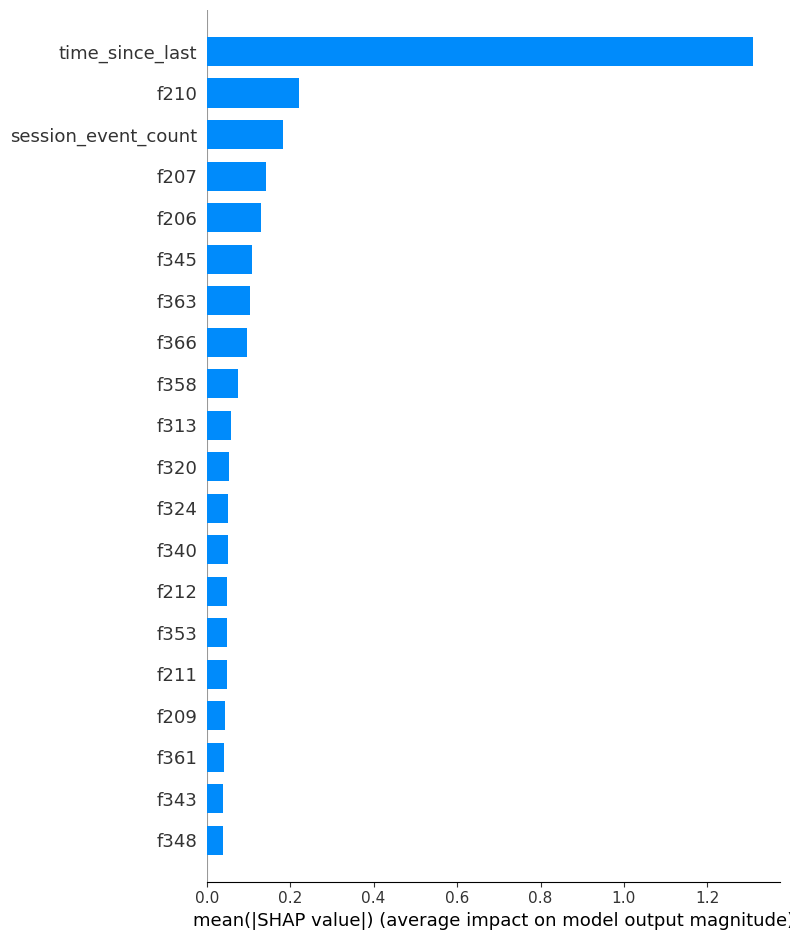


--- Waterfall Plot for a Single Prediction ---


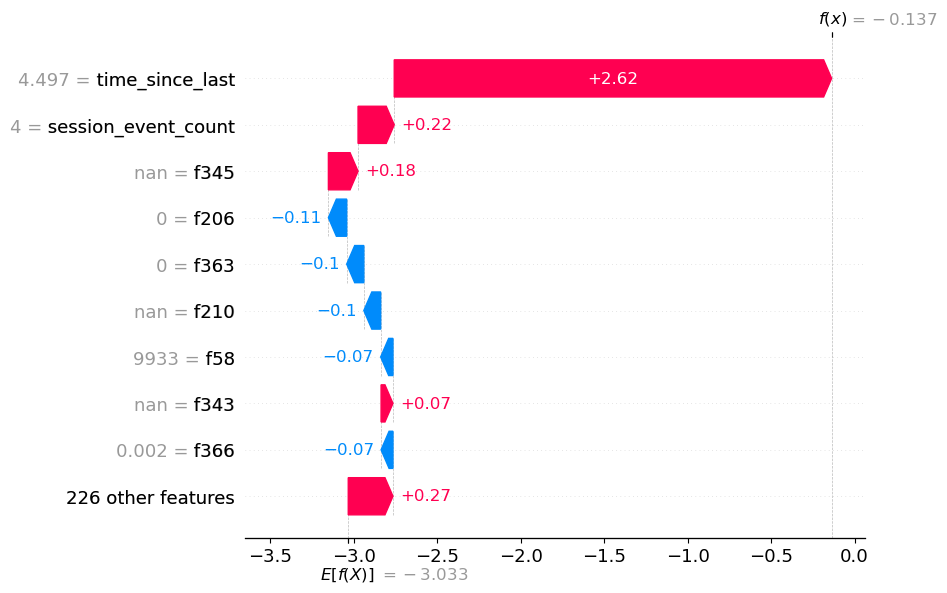

In [61]:
# plot shap waterfall plot
import shap
import matplotlib.pyplot as plt

# --- 1. Initialize Explainer and Calculate SHAP Values ---
print("Initializing SHAP TreeExplainer...")
# Create the explainer object with your trained CatBoostRanker model
explainer = shap.TreeExplainer(model)

print("Calculating SHAP values for the sample data...")
# Calculate the SHAP values. This can take a moment.
shap_values = explainer.shap_values(X_train_sample)


# --- 2. Print Aggregated SHAP Values (Global Feature Importance) ---
# The summary plot is the best way to visualize the overall importance.
print("\n--- Global Feature Importance (Summary Plot) ---")
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")


# --- 3. Create a Waterfall Plot for a Single Prediction ---
# A waterfall plot explains how each feature contributes to one specific prediction.
# Let's explain the prediction for the first row in our sample.
print("\n--- Waterfall Plot for a Single Prediction ---")

# The explainer object has an expected_value (the baseline score for all predictions)
# We use the SHAP values and feature values for the first instance (index 0)
shap.waterfall_plot(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_train_sample.iloc[0],
    feature_names=X_train_sample.columns.tolist()
))

In [62]:
import pandas as pd
import numpy as np

# Assume 'shap_values' and 'X_val_sample' are already calculated from the previous step

# 1. Calculate the mean absolute SHAP value for each feature
# This summarizes the impact of each feature across all the samples
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 2. Create a pandas DataFrame for easy viewing
shap_df = pd.DataFrame({
    'feature_name': X_train_sample.columns,
    'mean_abs_shap_value': mean_abs_shap
})

# 3. Sort the DataFrame to see the most impactful features at the top
shap_df = shap_df.sort_values('mean_abs_shap_value', ascending=False).reset_index(drop=True)

# 4. Display the resulting table
print("--- Top 25 Most Important Features (based on Mean SHAP Value) ---")
shap_df

--- Top 25 Most Important Features (based on Mean SHAP Value) ---


,feature_name,mean_abs_shap_value
0,time_since_last,1.308726
1,f210,0.221948
2,session_event_count,0.183219
3,f207,0.142688
4,f206,0.129626
...,...,...
230,f333,0.000000
231,f332,0.000000
232,f129,0.000000
233,f128,0.000000


In [63]:
removal=shap_df[shap_df['mean_abs_shap_value']==0]['feature_name'].to_list()

In [65]:
train.drop(columns=removal, inplace=True)
val.drop(columns=removal, inplace=True)

In [66]:
train

,id2,id3,id4,id5,y,f1,f2,f5,f6,f7,...,f366,f349_sin,time_since_last,session_event_count,offer_category,num_offer_categories,sub_category,num_sub_categories,previous_offer_category,previous_suboffer_category
0,1000624,5243695,2023-11-01 03:31:21.598,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,0.000000,-0.433884,NaN,1,Shopping,1,Other,1,missing,missing
1,1000624,97646,2023-11-01 03:31:21.618,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,0.000000,-0.433884,0.020,2,Shopping,1,Apparel,1,Shopping,Other
2,1000639,81010,2023-11-01 13:00:17.848,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,0.005056,-0.433884,NaN,1,Shopping,1,Other,1,missing,missing
3,1000639,830157,2023-11-01 13:00:20.013,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,0.005056,-0.433884,2.165,2,Shopping,1,Gifts,1,Shopping,Other
4,1000639,24840,2023-11-01 13:00:22.564,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,0.007229,-0.433884,2.551,3,Shopping,1,Clothing_Gifts_Jewelry,3,Shopping,Gifts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124373,1910541,80107221,2023-11-01 05:46:56.017,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,0.000000,-0.433884,1.993,3,Shopping,1,Other,1,Services,None
124374,1910541,224505,2023-11-01 07:43:02.618,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,0.000000,-0.433884,6966.601,4,Shopping,1,Other,1,Shopping,Other
124375,1910541,5420674,2023-11-01 07:43:31.173,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,0.000000,-0.433884,28.555,5,Shopping,1,Other,1,Shopping,Other
124376,1910541,82192,2023-11-01 07:43:31.452,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,0.000000,-0.433884,0.279,6,Shopping,1,Clothing,1,Shopping,Other


In [67]:
# save them as feature_removed_small_train
train.to_parquet('../Data/feature_removed_small_train.parquet', index=False)
val.to_parquet('../Data/feature_removed_small_val.parquet', index=False)